#📁Data Loading


##Importing libraries

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from timeit import default_timer as timers
import pickle
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mrse


<ipython-input-17-ef8b5044ef3e>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading Data

In [ ]:
# Define column names based on the description
column_names = ['Year', 'Month', 'Date_Fraction', 'Sunspots_Number', 'St_Deviation', 'Nobs', 'Indicator']

# Read the CSV file and add column names
df = pd.read_csv('/content/drive/MyDrive/Monthly_Sunspots.csv', sep=';', names=column_names)

# Count missing values in 'Sunspots_Number'
missing_values = df['Sunspots_Number'].value_counts()
num_missing_values = missing_values[-1] if -1 in missing_values else 0

# Delete rows with missing values in 'Sunspots_Number'
df = df[df['Sunspots_Number'] != -1]

# Keep only the specified columns
df = df[['Year', 'Month', 'Date_Fraction', 'Sunspots_Number']]

# Display the resulting DataFrame
df


,Year,Month,Date_Fraction,Sunspots_Number
0,1749,1,1749.042,96.7
1,1749,2,1749.123,104.3
2,1749,3,1749.204,116.7
3,1749,4,1749.288,92.8
4,1749,5,1749.371,141.7
...,...,...,...,...
3300,2024,1,2024.042,123.0
3301,2024,2,2024.124,124.7
3302,2024,3,2024.206,104.9
3303,2024,4,2024.288,136.5


##Adding Date Column

In [ ]:
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))  # Add a date column with 1
df = df[['Date', 'Year', 'Month', 'Date_Fraction', 'Sunspots_Number']]
df

,Date,Year,Month,Date_Fraction,Sunspots_Number
0,1749-01-01,1749,1,1749.042,96.7
1,1749-02-01,1749,2,1749.123,104.3
2,1749-03-01,1749,3,1749.204,116.7
3,1749-04-01,1749,4,1749.288,92.8
4,1749-05-01,1749,5,1749.371,141.7
...,...,...,...,...,...
3300,2024-01-01,2024,1,2024.042,123.0
3301,2024-02-01,2024,2,2024.124,124.7
3302,2024-03-01,2024,3,2024.206,104.9
3303,2024-04-01,2024,4,2024.288,136.5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3305 entries, 0 to 3304
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             3305 non-null   datetime64[ns]
 1   Year             3305 non-null   int64         
 2   Month            3305 non-null   int64         
 3   Date_Fraction    3305 non-null   float64       
 4   Sunspots_Number  3305 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 129.2 KB


##Converting date into datetime

In [ ]:
from dateutil.parser import parse
dateparse=lambda dates:parse(dates)

In [ ]:
from operator import index
print(df.index)

RangeIndex(start=0, stop=3305, step=1)


#⚙️Exploratory Data Analysis

In [ ]:
df_copy=df.copy() # Making a copy of initial data

###Extracting the each year of the decade.

In [ ]:
df_copy['nth_year'] =[int(str(i)[3]) for i in (df_copy.Date.dt.year)] # Note this is list comprehension
df_copy['nth_year'].replace(0,10,inplace=True)
df_copy.head(10)

,Date,Year,Month,Date_Fraction,Sunspots_Number,nth_year
0,1749-01-01,1749,1,1749.042,96.7,9
1,1749-02-01,1749,2,1749.123,104.3,9
2,1749-03-01,1749,3,1749.204,116.7,9
3,1749-04-01,1749,4,1749.288,92.8,9
4,1749-05-01,1749,5,1749.371,141.7,9
5,1749-06-01,1749,6,1749.455,139.2,9
6,1749-07-01,1749,7,1749.538,158.0,9
7,1749-08-01,1749,8,1749.623,110.5,9
8,1749-09-01,1749,9,1749.707,126.5,9
9,1749-10-01,1749,10,1749.790,125.8,9


## Plotting the data using Seaborn Boxplot

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14), dpi=80)

sns.boxplot(
    x='Date_Fraction', y='Sunspots_Number', data=df_copy, ax=axes[0],
    palette="Set3",  # Choose a color palette from Seaborn
    showmeans=True,  # Show the mean as a point within the box
    notch=True,      # Add notches to the boxes for confidence intervals
    linewidth=2      # Adjust line width for boxes and medians
)

sns.boxplot(
    x='Month', y='Sunspots_Number', data=df_copy, ax=axes[1],
    palette="tab10",  # Choose a different color palette
    flierprops=dict(markerfacecolor="red"),  # Color outliers red
    medianprops=dict(linewidth=3, color="green")  # Customize median line
)

sns.boxplot(
    x='nth_year', y='Sunspots_Number', data=df_copy, ax=axes[2],
    palette="YlGnBu",  # Choose another color palette
    saturation=0.7,  # Reduce color saturation for a softer look
    boxprops=dict(facecolor="lightblue", alpha=0.7)  # Adjust box fill color and transparency
)

# Set Titles
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=14)
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=14)
axes[2].set_title('Nth_year_each_decade\n(The Seasonality)', fontsize=14)

fig.tight_layout()
plt.show()


<ipython-input-18-1b498c75b2ca>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7c5d790bf130> (for post_execute):


KeyboardInterrupt: 


* The distribution of data is almost same in each month with few outliers
* The distribution of data among each year of the decades are not same .


##Setting an index so we can easily slice

In [ ]:
df = df.set_index('Date') # Setting an index so we can easily slice

In [ ]:
df.head()
# df.tail()

,Year,Month,Date_Fraction,Sunspots_Number
Date,,,,
1749-01-01,1749,1,1749.042,96.7
1749-02-01,1749,2,1749.123,104.3
1749-03-01,1749,3,1749.204,116.7
1749-04-01,1749,4,1749.288,92.8
1749-05-01,1749,5,1749.371,141.7


##Sunspots Plot

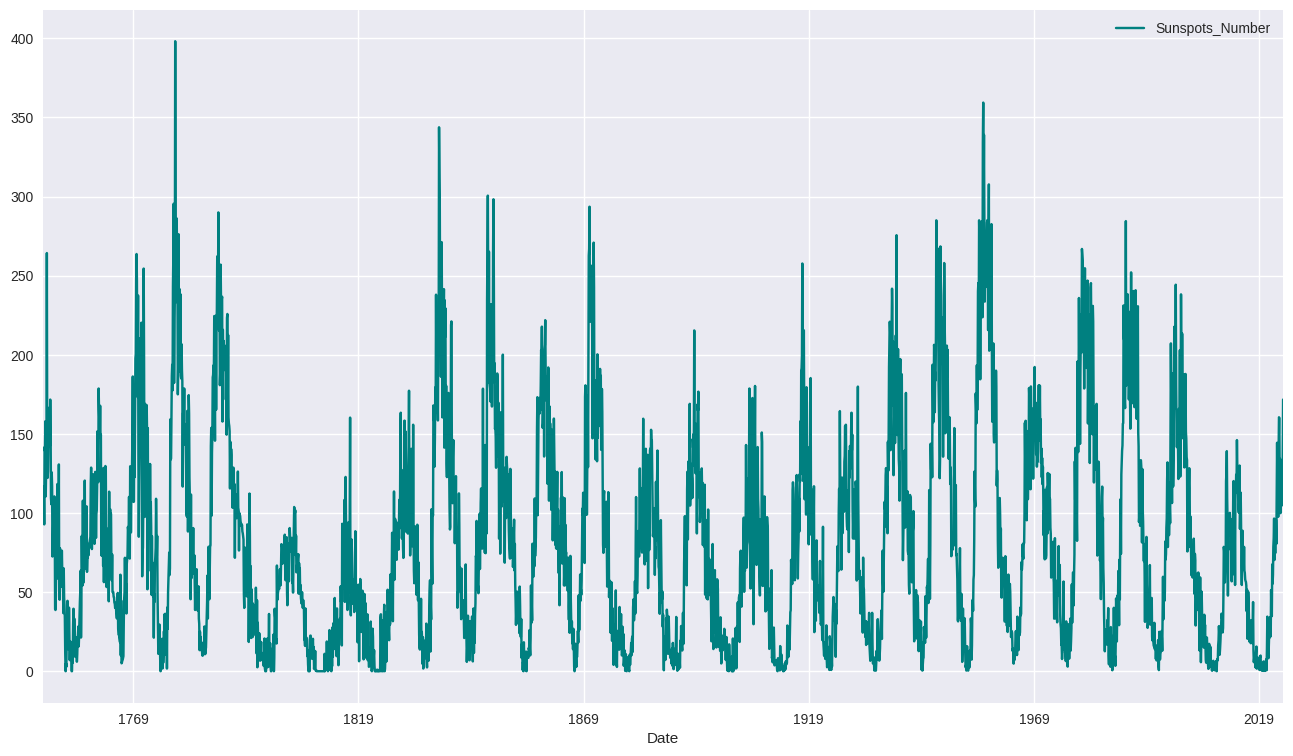

In [ ]:

# Desired columns to plot
desired_columns = ['Sunspots_Number']

# Plot only the desired columns with teal color
df[desired_columns].plot(color='teal', grid=True)

# Display the plot
plt.show()

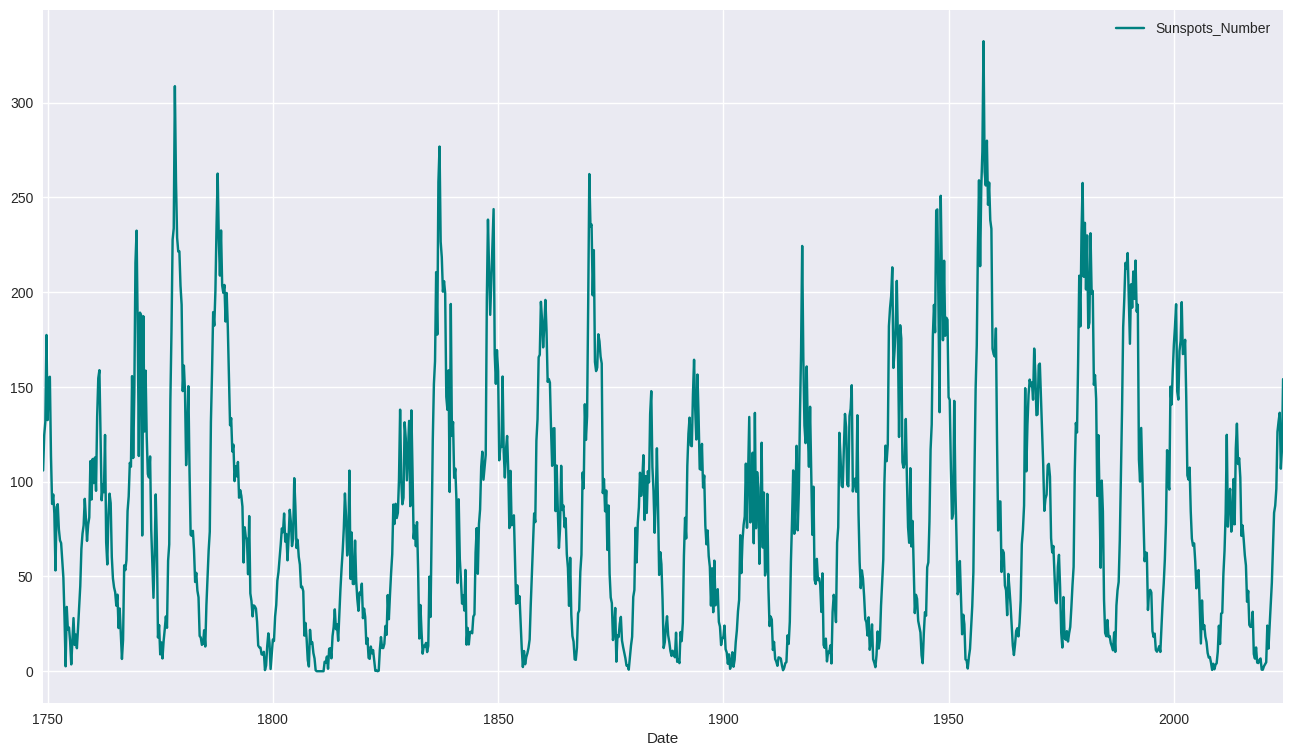

In [ ]:
df_quarterly = df.resample('Q').mean()

# Desired columns to plot
desired_columns = ['Sunspots_Number']

# Plot only the desired columns with teal color
df_quarterly[desired_columns].plot(color='teal', grid=True)

# Display the plot
plt.show()

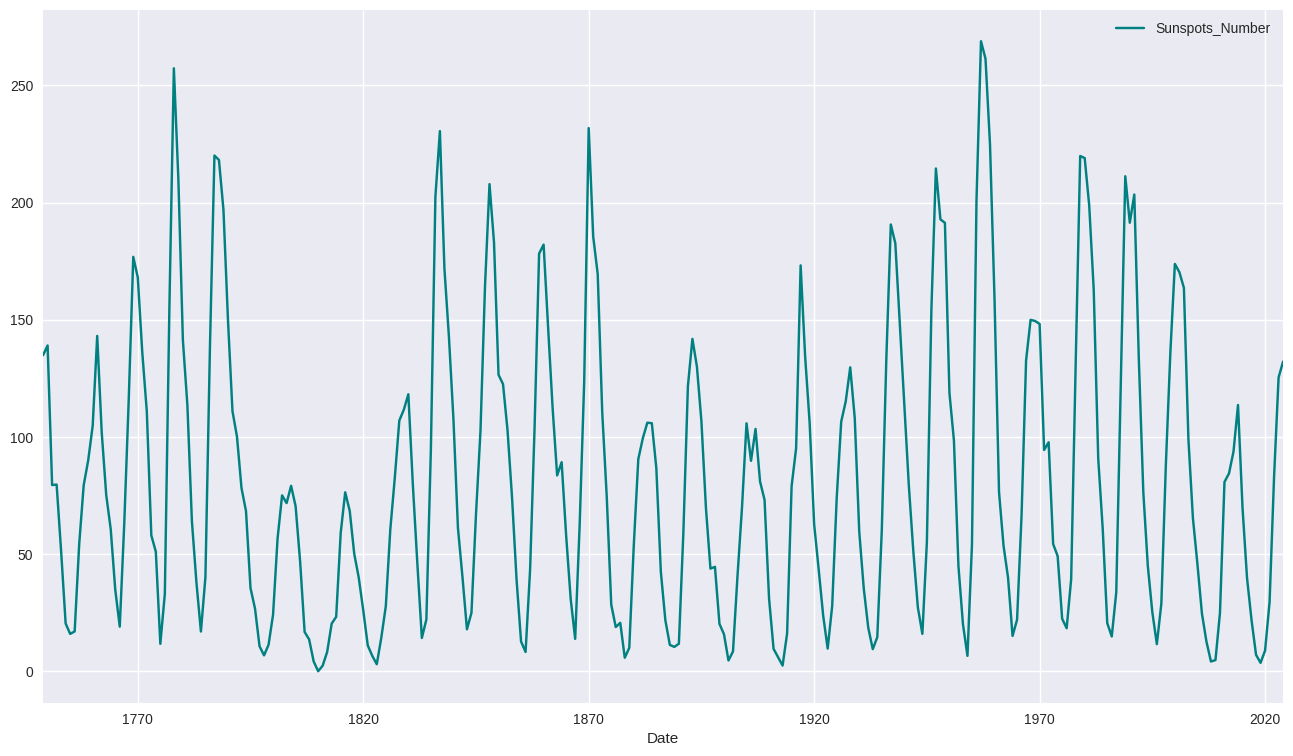

In [ ]:
df_yearly = df.resample('A').mean()

# Desired columns to plot
desired_columns = ['Sunspots_Number']

# Plot only the desired columns with teal color
df_yearly[desired_columns].plot(color='teal', grid=True)

# Display the plot
plt.show()

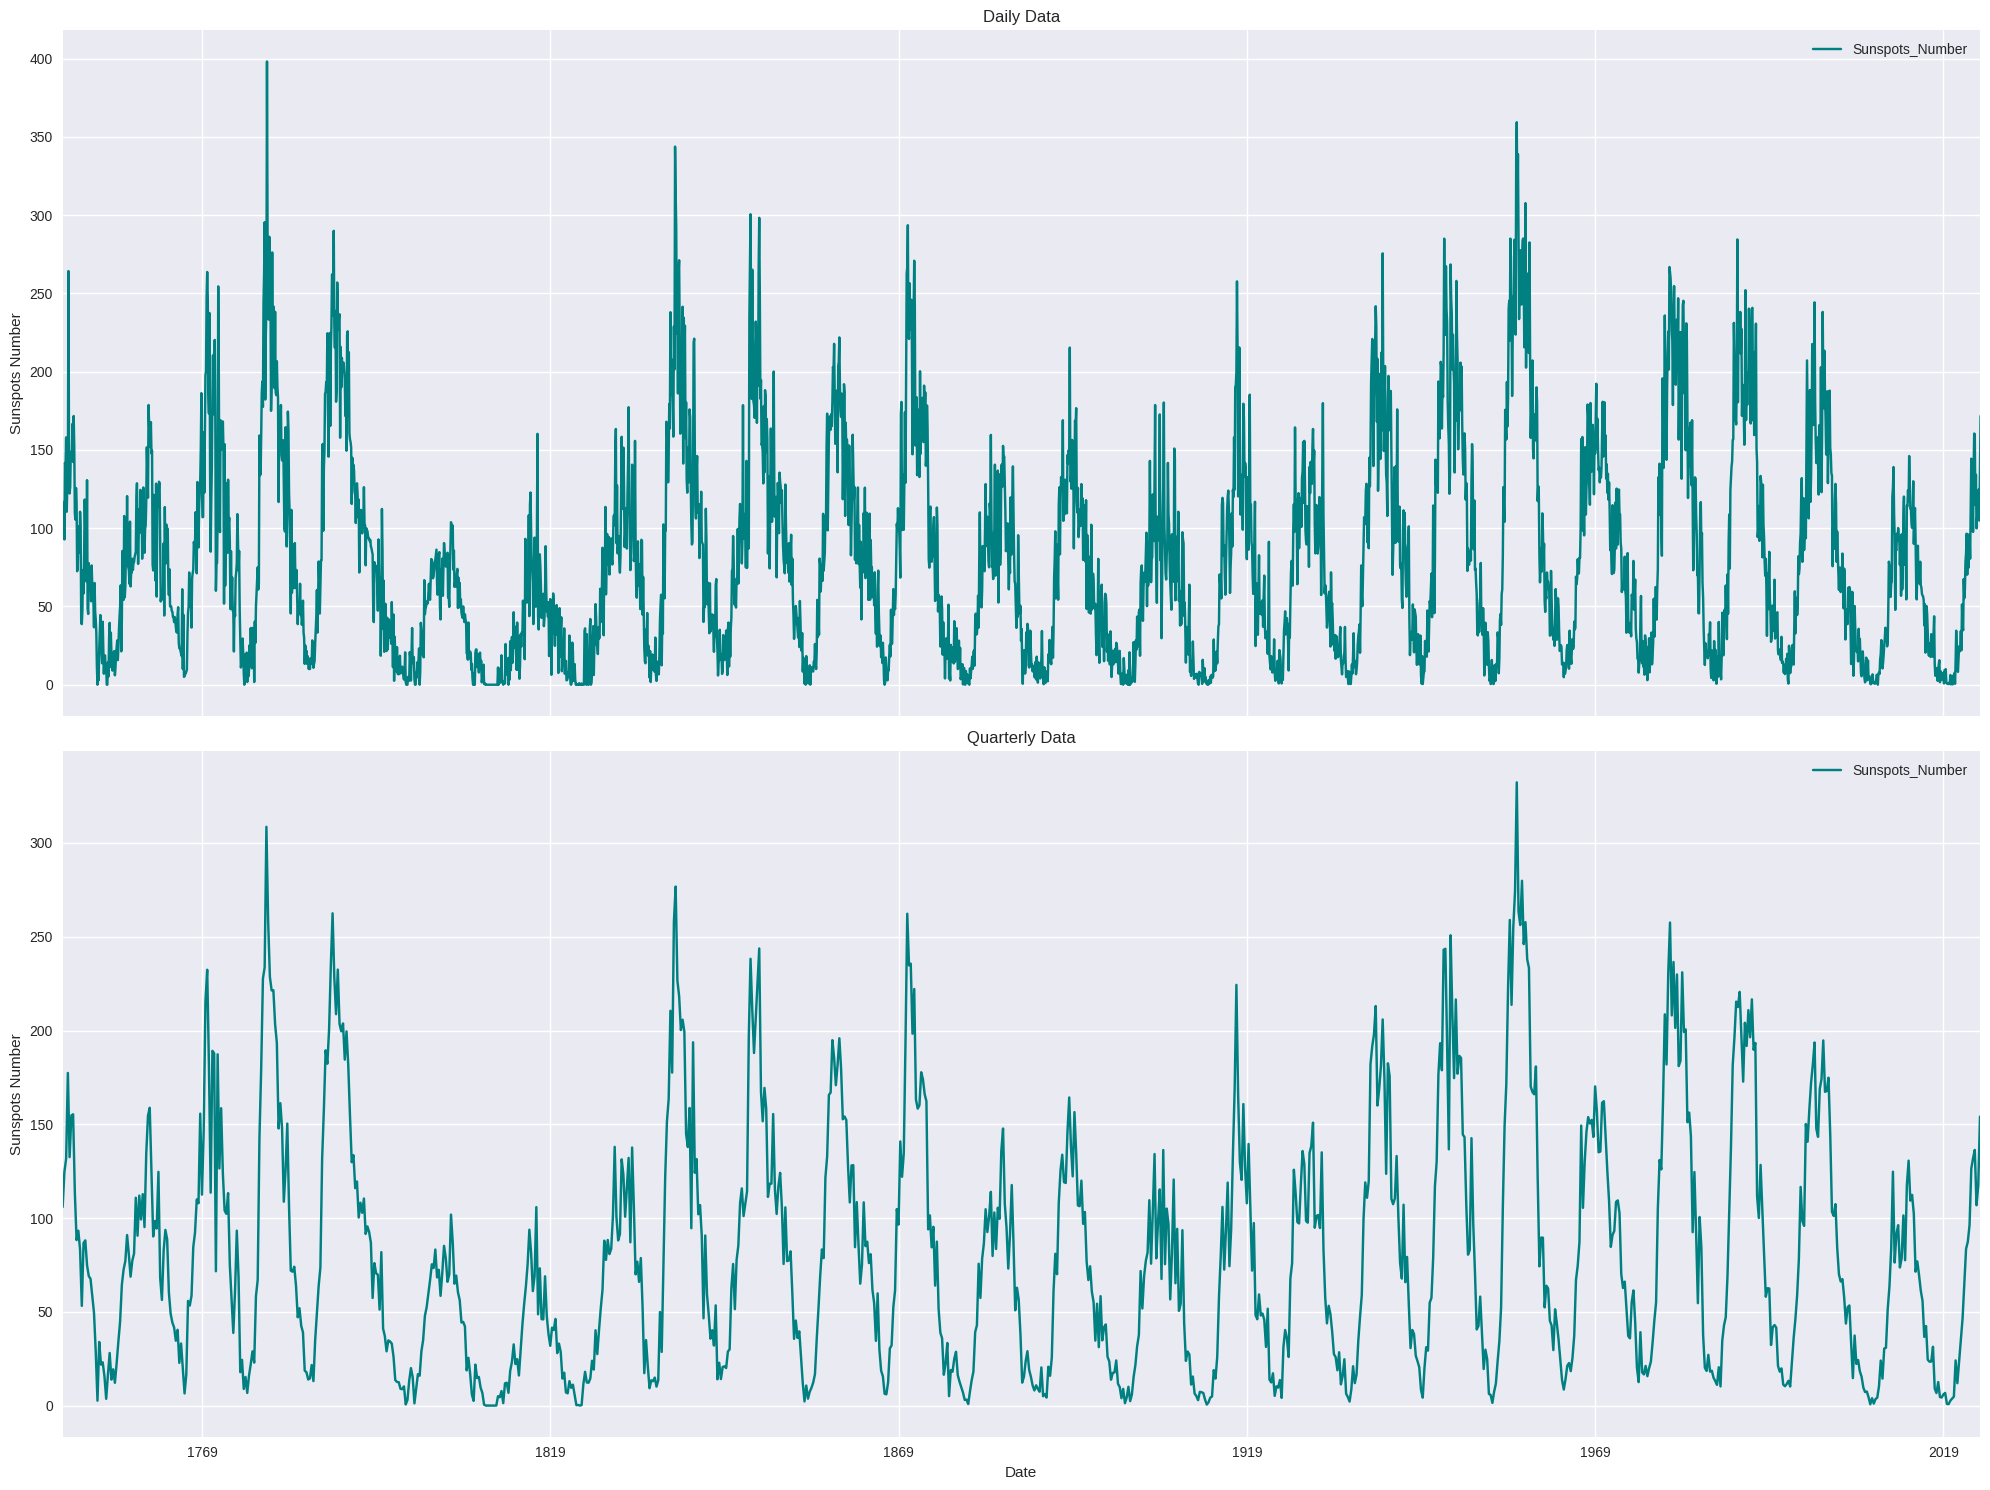

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15), sharex=True)

# Daily plot
df[desired_columns].plot(ax=axes[0], color='teal', grid=True)
axes[0].set_title('Daily Data')
axes[0].set_ylabel('Sunspots Number')

# Quarterly plot
df_quarterly = df.resample('Q').mean()
df_quarterly[desired_columns].plot(ax=axes[1], color='teal', grid=True)
axes[1].set_title('Quarterly Data')
axes[1].set_ylabel('Sunspots Number')

# # Yearly plot
# df_yearly = df.resample('A').mean()
# df_yearly[desired_columns].plot(ax=axes[2], color='teal', grid=True)
# axes[2].set_title('Yearly Data')
# axes[2].set_ylabel('Sunspots Number')

# Set common x-axis label
axes[1].set_xlabel('Date')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

Slicing the data and visualise any particular time zone.

##Sliced Sunspots Plot

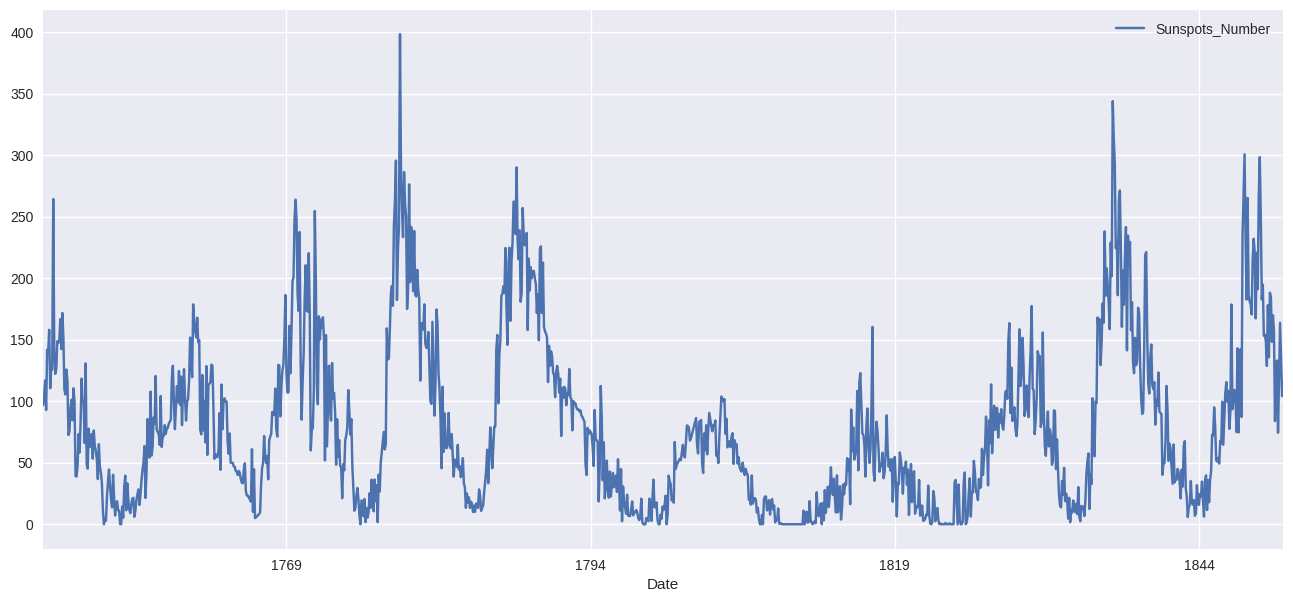

In [ ]:
desired_columns = ['Sunspots_Number']

df_2018 = df.loc['1749':'1850']

# Plot the desired column with grid
df_2018[desired_columns].plot(figsize=(16, 7), grid=True)
plt.show()

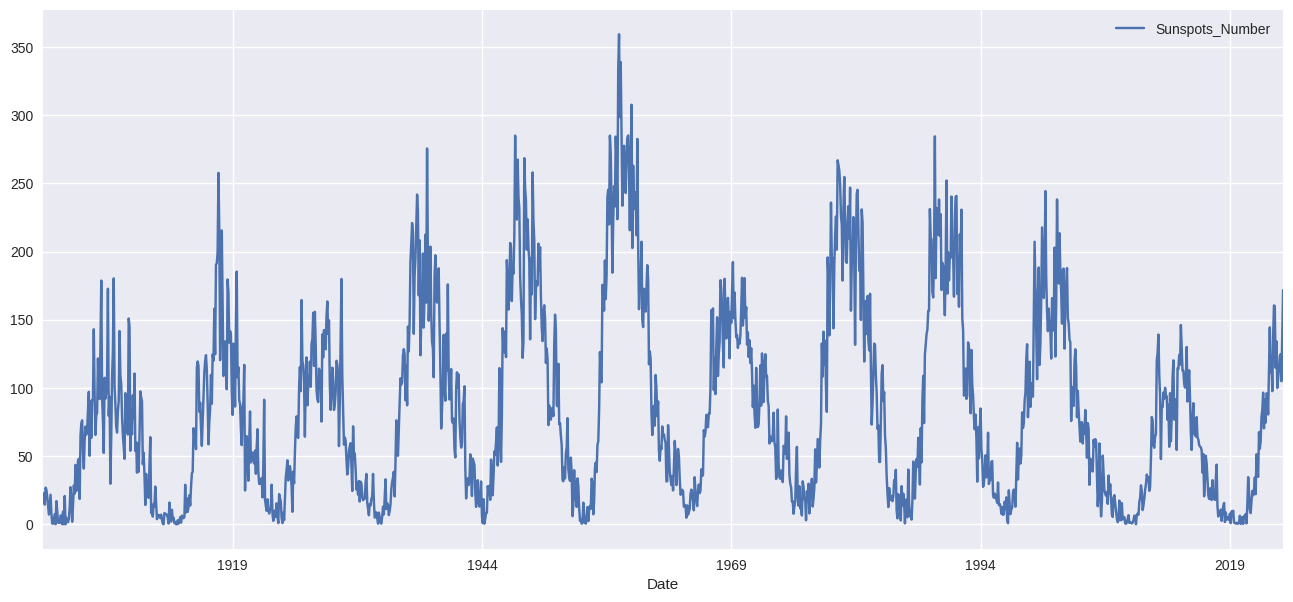

In [ ]:
desired_columns = ['Sunspots_Number']
df_2018 = df.loc['1900':'2024']
df_2018[desired_columns].plot(figsize=(16, 7), grid=True)
plt.show()

##Comparing Different Time Sections

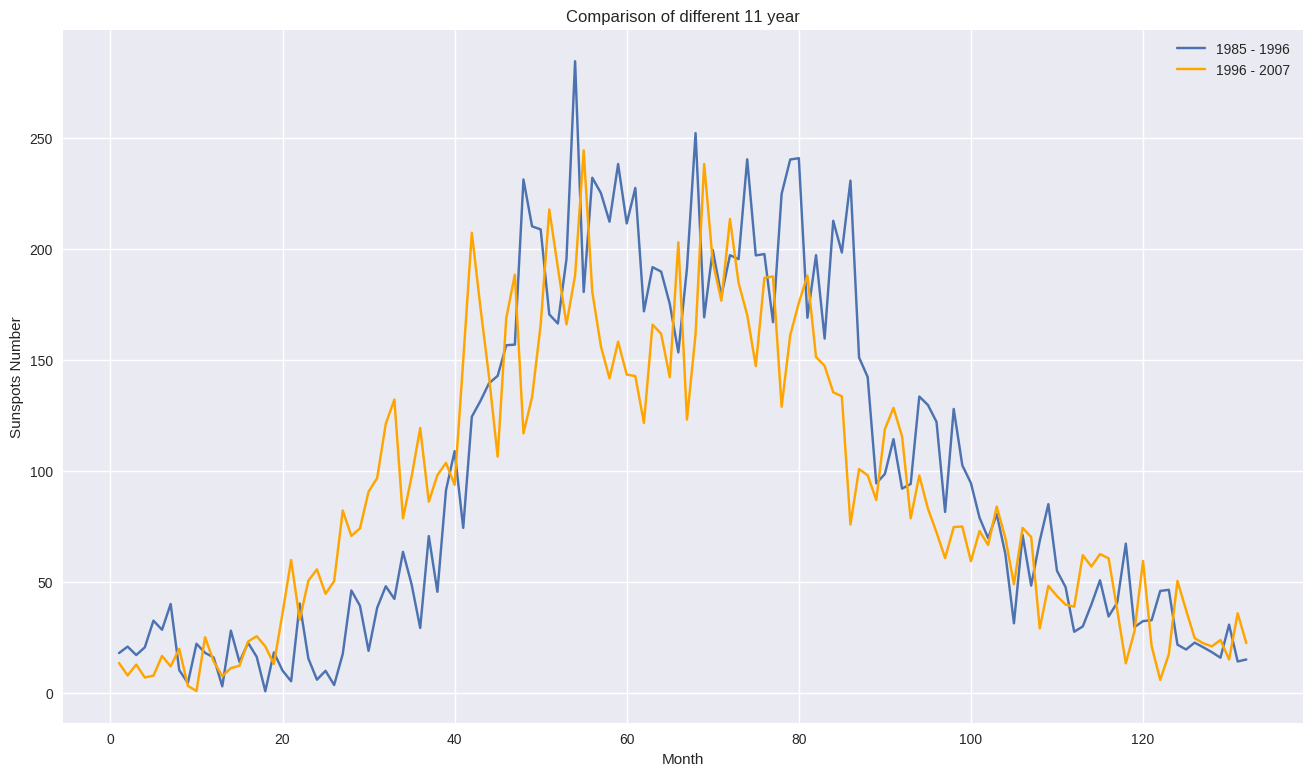

In [ ]:
df_11_1985=df_copy[(df_copy.Date.dt.year>=1985) & (df_copy.Date.dt.year<1996)]
df_11_1996=df_copy[(df_copy.Date.dt.year>=1996) &(df_copy.Date.dt.year<2007)]

x=np.arange(1,len(df_11_1996['Date'])+1)
plt.figure()
plt.plot(x, df_11_1985['Sunspots_Number'],label='1985 - 1996')
plt.plot(x, df_11_1996['Sunspots_Number'],label='1996 - 2007', color='orange')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Sunspots Number')
plt.title('Comparison of different 11 year')
plt.show()

## Plotly Express

Plotly express provide slider and button to select particular time zone.

In [ ]:
import plotly.express as px
fig = px.line(df_copy, x='Date', y='Sunspots_Number', title='Monthly_Sunspot_Slider')
fig.update_xaxes(rangeslider_visible=False)
fig.show()


## Buttons options in Plotly

In [ ]:
fig = px.line(df_copy, x='Date', y='Sunspots_Number', title='Mean Sunspots Number Slider')

fig.update_xaxes(
    rangeslider_visible=False,
    rangeselector=dict(
        buttons=list([
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(count=20, label="20y", step="year", stepmode="backward"),
            dict(count=30, label="30y", step="year", stepmode="backward"),
            dict(count=40, label="40y", step="year", stepmode="backward"),
            dict(count=50, label="50y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

## Lag plot

* It helps to understand the autocorrelation lag, visualizing for few.
* As we increase the lag time, the correlation is decresing.
* The data is correlated with its recet time lag upt 4/5 time lag.

In [ ]:
fig=plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
ax1=fig.add_subplot(2,2,1)
pd.plotting.lag_plot(df['Sunspots_Number'],lag=1)
plt.title('Lag_1')
ax2=fig.add_subplot(2,2,2)
pd.plotting.lag_plot(df['Sunspots_Number'],lag=2)
plt.title('Lag_2')
ax3=fig.add_subplot(2,2,3)
pd.plotting.lag_plot(df['Sunspots_Number'],lag=11)
plt.title('Lag_11')
ax3=fig.add_subplot(2,2,4)
pd.plotting.lag_plot(df['Sunspots_Number'],lag=132)
plt.title('Lag_132')
plt.show()

Seasonal Extraction

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
array = df['Sunspots_Number'].to_numpy()

In [ ]:
decomposition = seasonal_decompose(array, model='additive', filt=None, period=132, two_sided=True, extrapolate_trend=0)

# Access components
seasonal = decomposition.seasonal
trend = decomposition.trend
residual = decomposition.resid

In [ ]:
decomposition.plot()  # Plot on the created figure

# 2. Checking Stationarity of Time Series Data
* From the plot of data we can see that the it is stationary, though we have to check it statistically.

* Two test for stationarity: ADF & KPSS test



## Perform Augumented Dickey-Fuller test:


* Null Hypothesis - Series is not stationary

* Alternate Hypothesis - Series is stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
data_series=df['Sunspots_Number']

In [ ]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(data_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)
if dfoutput['Test Statistic'] < dfoutput['Critical Value (5%)']:  ## Comparing with 5% significant Level
  print('Series is stationary')
else:
  print('Series is not Stationary')
## OR
# if dfoutput[1] > 0.05 :
#   print('Series is not Stationary')
# else:
#   print('Series is Stationary')

Results of Dickey-Fuller Test:
Test Statistic                -1.061184e+01
p-value                        5.807026e-19
#Lags Used                     2.800000e+01
Number of Observations Used    3.276000e+03
Critical Value (1%)           -3.432348e+00
Critical Value (5%)           -2.862423e+00
Critical Value (10%)          -2.567240e+00
dtype: float64
Series is stationary


## KPSS test for stationary
* Null hypothesis - Series is stationary
* Alternate hypothesis - Series is not stationary

In [ ]:
from statsmodels.tsa.stattools import kpss

In [ ]:
from statsmodels.tsa.stattools import kpss

# Adjusting lags and ensuring the correct regression component is used
stats, p_value, lags, critical_values = kpss(df['Sunspots_Number'], regression='c', nlags='auto')

print('KPSS Statistic:', stats)
print('p-value:', p_value)
print('Critical Values:', critical_values)


KPSS Statistic: 0.1036909720229914
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


<ipython-input-86-22bf4fabaf63>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [ ]:
print(f'Test Statistics: {stats}')
print(f'p-value: {p}')
print(f'Critial Values: {critical_values}')

if p < 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: 0.1171592606458555
p-value: 0.1
Critial Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Series is Stationary


#🔮SARIMA Predictions

In [ ]:
import statsmodels.api as sm


In [ ]:
import pandas as pd

# Define column names based on the description
column_names = ['Year', 'Month', 'Date_Fraction', 'Sunspots_Number', 'St_Deviation', 'Nobs', 'Indicator']

# Read the CSV file and add column names
df = pd.read_csv('/content/drive/MyDrive/Monthly_Sunspots.csv', sep=';', names=column_names)

# Count missing values in 'Sunspots_Number'
missing_values = df['Sunspots_Number'].value_counts()
num_missing_values = missing_values[-1] if -1 in missing_values else 0

# Delete rows with missing values in 'Sunspots_Number'
df = df[df['Sunspots_Number'] != -1]

# Keep only the specified columns
df = df[['Year', 'Month', 'Date_Fraction', 'Sunspots_Number']]

# Add the column Date
df['Date'] = df[['Year', 'Month']].apply(lambda s: pd.Timestamp(year=s['Year'], month=s['Month'], day=1), axis=1)

# Set Date column as the index of the dataframe
df.set_index('Date', inplace=True)

# Display the resulting DataFrame
df


,Year,Month,Date_Fraction,Sunspots_Number
Date,,,,
1749-01-01,1749,1,1749.042,96.7
1749-02-01,1749,2,1749.123,104.3
1749-03-01,1749,3,1749.204,116.7
1749-04-01,1749,4,1749.288,92.8
1749-05-01,1749,5,1749.371,141.7
...,...,...,...,...
2024-01-01,2024,1,2024.042,123.0
2024-02-01,2024,2,2024.124,124.7
2024-03-01,2024,3,2024.206,104.9


##Basic Load-Plot

###Quarter resampling

The code ts_quarter = ts.resample('Q').mean() is resampling the time series ts into quarterly frequency ('Q') and then taking the mean within each quarter. resampling time series data to a quarterly frequency can provide a clearer view of underlying trends and patterns, reduce noise, and align data analysis with standard reporting intervals.

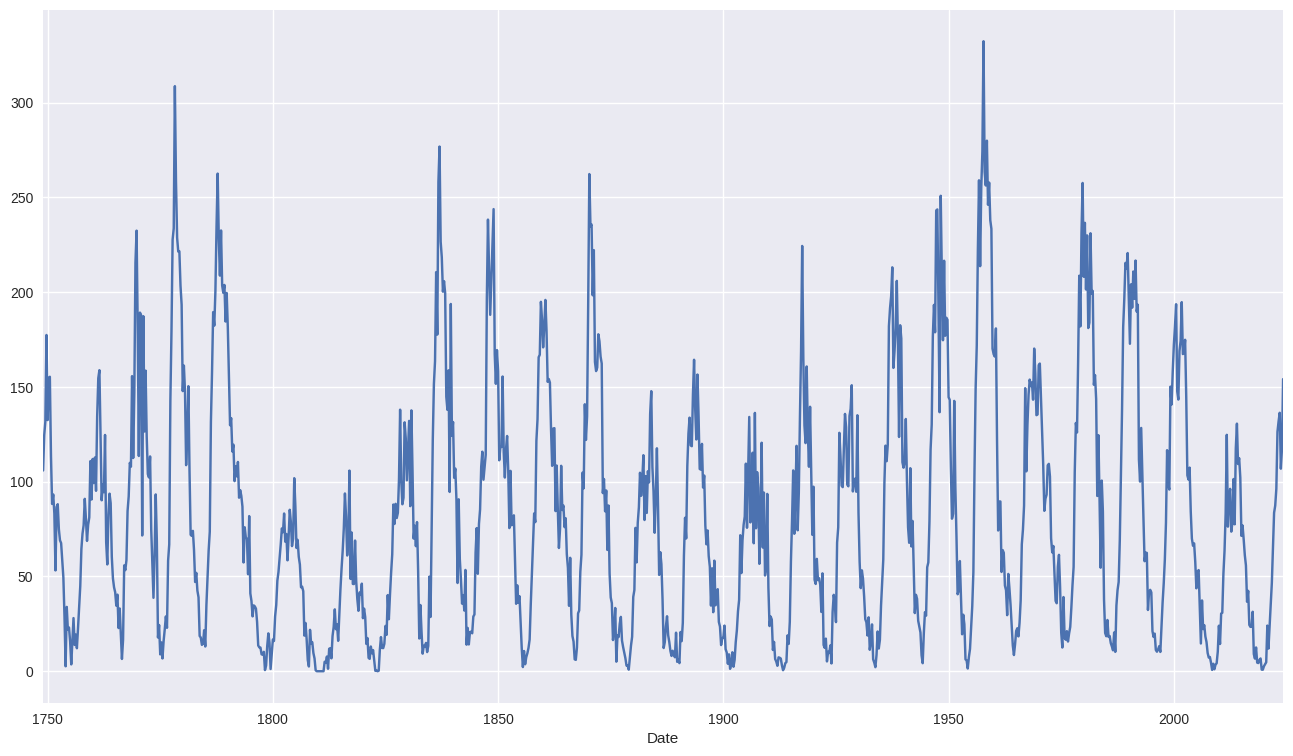

In [ ]:
ts = pd.Series(data=df.Sunspots_Number, index=df.index)
ts_quarter = ts.resample('Q').mean()
ts_quarter.plot()
plt.show()

In [ ]:
ts_quarter

Date
1749-03-31    105.900000
1749-06-30    124.566667
1749-09-30    131.666667
1749-12-31    177.366667
1750-03-31    132.466667
                 ...    
2023-06-30    131.833333
2023-09-30    136.333333
2023-12-31    106.833333
2024-03-31    117.533333
2024-06-30    154.100000
Freq: Q-DEC, Name: Sunspots_Number, Length: 1102, dtype: float64

In [ ]:
negative_values = ts_quarter < 0
any_negative_values = negative_values.any()

print(f"Are there any negative values in 'Sunspots_Number'? {any_negative_values}")


Are there any negative values in 'Sunspots_Number'? False


###Sunspots PACF

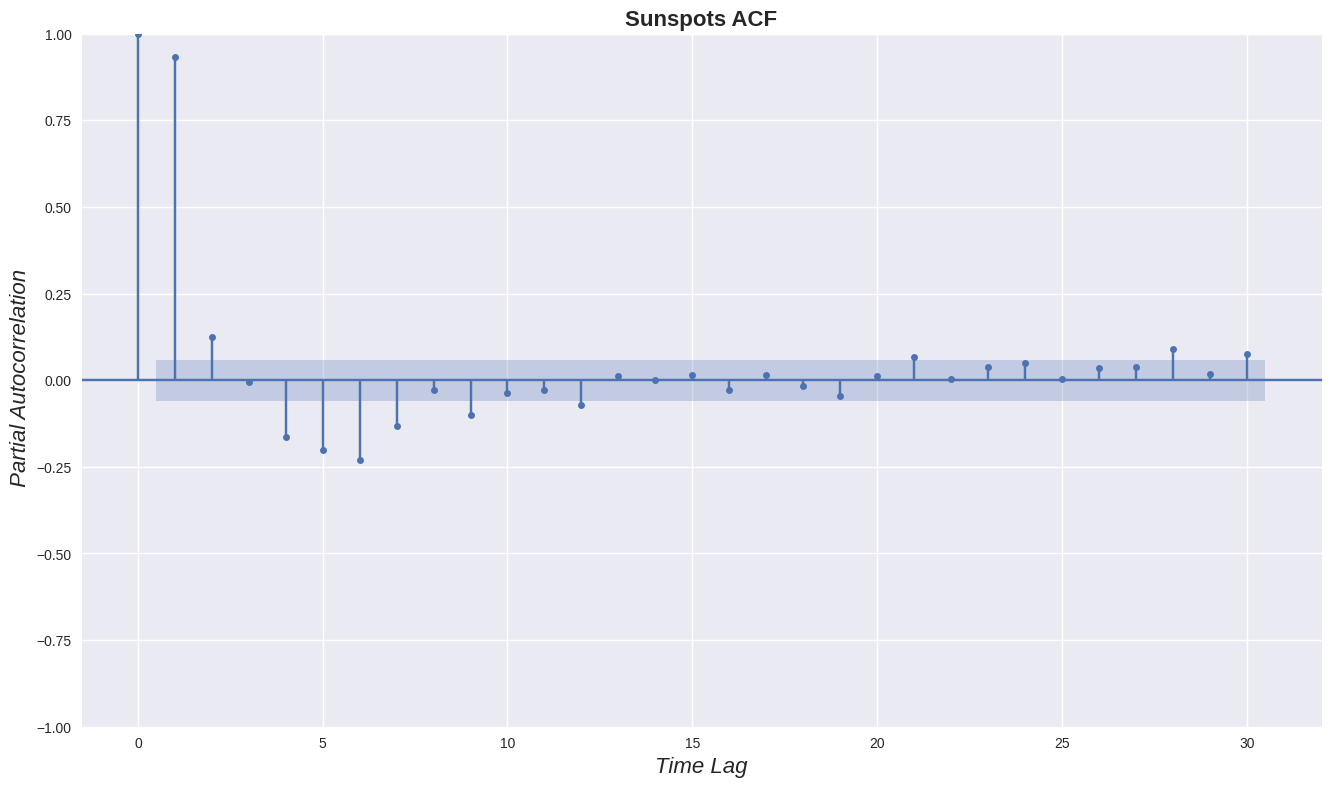

<Figure size 700x500 with 0 Axes>

In [ ]:
plot_pacf(ts_quarter, lags=30)
plt.title('Sunspots ACF', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Time Lag', fontdict={'fontsize': 16, 'fontstyle': 'oblique'})
plt.ylabel(' Partial Autocorrelation', fontdict={'fontsize': 16, 'fontstyle': 'oblique'})

plt.figure(figsize=(7, 5))
plt.show()

###Sunspots ACF

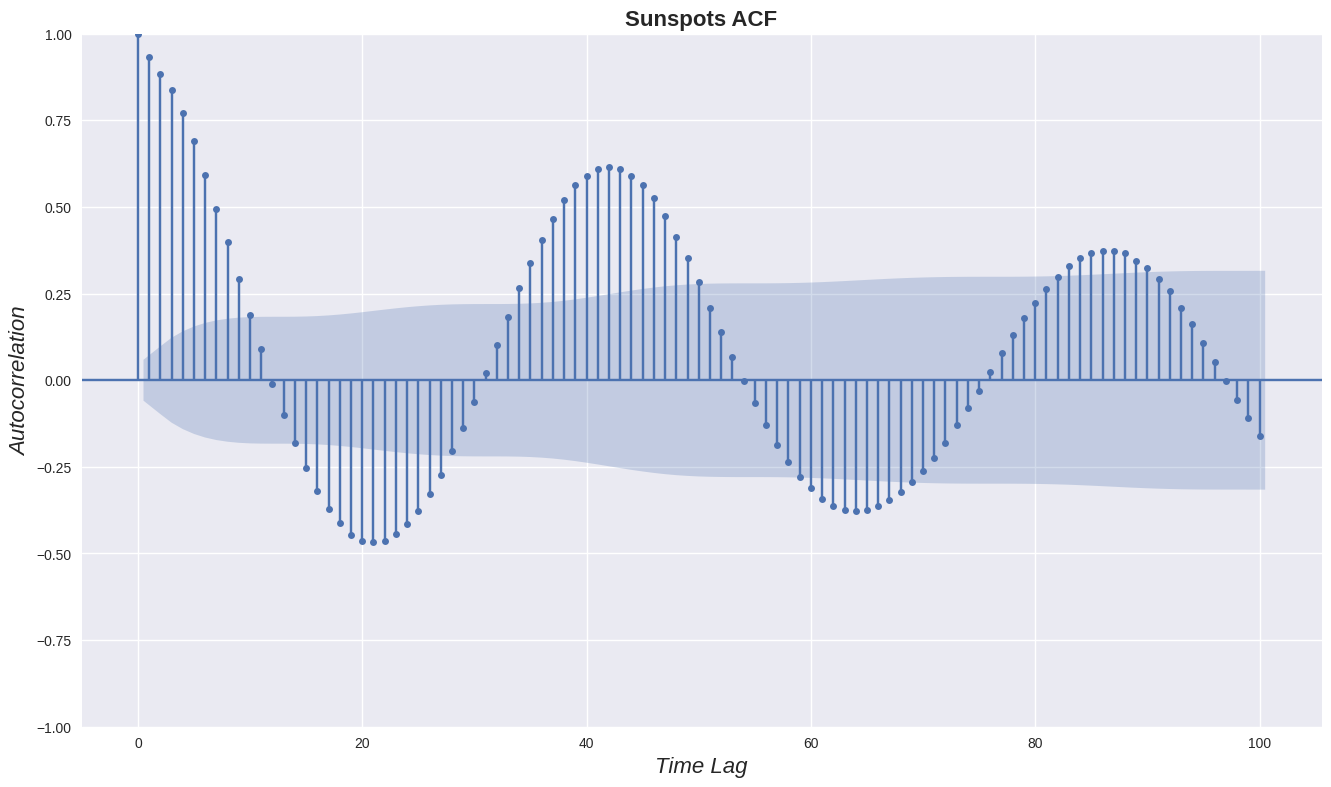

<Figure size 700x500 with 0 Axes>

In [ ]:
plot_acf(ts_quarter, lags=100, title='Sunspots ACF')

# Customize font properties
plt.title('Sunspots ACF', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Time Lag', fontdict={'fontsize': 16, 'fontstyle': 'oblique'})
plt.ylabel('Autocorrelation', fontdict={'fontsize': 16, 'fontstyle': 'oblique'})

# Set figure size
plt.figure(figsize=(7, 5))

# Display the plot
plt.show()

## SARIMA - Seasonal Autoregressive Integrated Moving Average


In order to configure a SARIMA(p,d,q)(P,D,Q)S, two kind of hyperparameters have to be set

#### Trend parameters
* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.(The purpose of differencing it to make the time series stationary.)
* q: The size of the moving average window, also called the order of moving average.
(The purpose of differencing it to make the time series stationary.)

#### Seasonal parameters
* P: Seasonal autoregressive order.
* D: Seasonal order of differencing.
* Q: Seasonal moving average order.
* S: The number of time steps for a single seasonal period.


###Model Fit

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm


# Step 1: Split the data into train_sarimaing and test_sarima sets
train_sarima_size = int(len(ts_quarter) * 0.90)  # Using 90% of data for train_sarimaing
train_sarima, test_sarima = ts_quarter.iloc[:train_sarima_size], ts_quarter.iloc[train_sarima_size:]


# Step 2: Train_sarima the model on the full train_sarimaing data
model_sarima = sm.tsa.statespace.SARIMAX(train_sarima, trend='n', order=(7,0,1), seasonal_order=(1,0,1,43))
results_sarima = model_sarima.fit()
print(results_sarima.summary())

# Step 3: Make predictions_sarima for the test_sarima set period
start_index = test_sarima.index[0]
end_index = test_sarima.index[-1]
predictions_sarima = results_sarima.predict(start=start_index, end=end_index, dynamic=False)

# # Ensure indices are aligned properly
# predictions_sarima.index = test_sarima.index

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                    Sunspots_Number   No. Observations:                  991
Model:             SARIMAX(7, 0, 1)x(1, 0, 1, 43)   Log Likelihood               -4514.866
Date:                            Thu, 25 Jul 2024   AIC                           9051.732
Time:                                    16:31:33   BIC                           9105.618
Sample:                                03-31-1749   HQIC                          9072.221
                                     - 09-30-1996                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2688      0.241      1.115      0.265      -0.204       0.741
ar.L2          0.5177      0.181   

###Prediction Plot

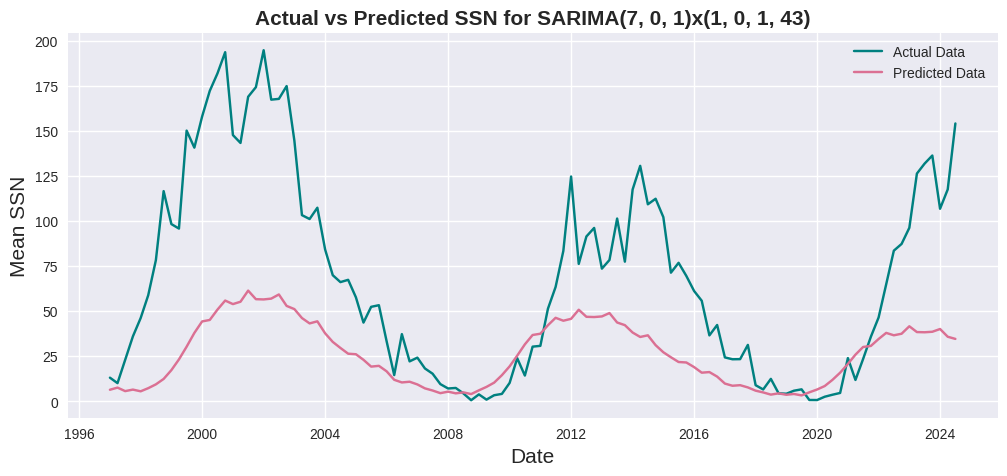

NameError: name 'mean_absolute_error' is not defined

In [ ]:
# Step 5: Plot the actual values and the forecasted values
plt.figure(figsize=(12, 5))
# plt.plot(train, label='Training Data')
plt.plot(test_sarima, label='Actual Data', color='teal')
plt.plot(predictions_sarima, label='Predicted Data', color='palevioletred')
plt.legend()
plt.title('Actual vs Predicted SSN for SARIMA(7, 0, 1)x(1, 0, 1, 43)', fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.xlabel('Date', fontdict={'fontsize': 15})
plt.ylabel('Mean SSN', fontdict={'fontsize': 15})
plt.show()
# Optional: Evaluate the performance using metrics like Mean Absolute Error (MAE)
mae = mean_absolute_error(test_sarima, predictions_sarima)
r2 = r2_score(test_sarima, predictions_sarima)
mse = mean_squared_error(test_sarima, predictions_sarima)
rmse = np.sqrt(mse)
print(f'Mean Absolute Error: {mae}')
print(f'Mean  Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')


###One Step Ahead Predictions


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                    Sunspots_Number   No. Observations:                  991
Model:             SARIMAX(7, 0, 1)x(1, 0, 1, 43)   Log Likelihood               -4514.866
Date:                            Thu, 25 Jul 2024   AIC                           9051.732
Time:                                    16:39:07   BIC                           9105.618
Sample:                                03-31-1749   HQIC                          9072.221
                                     - 09-30-1996                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2688      0.241      1.115      0.265      -0.204       0.741
ar.L2          0.5177      0.181   

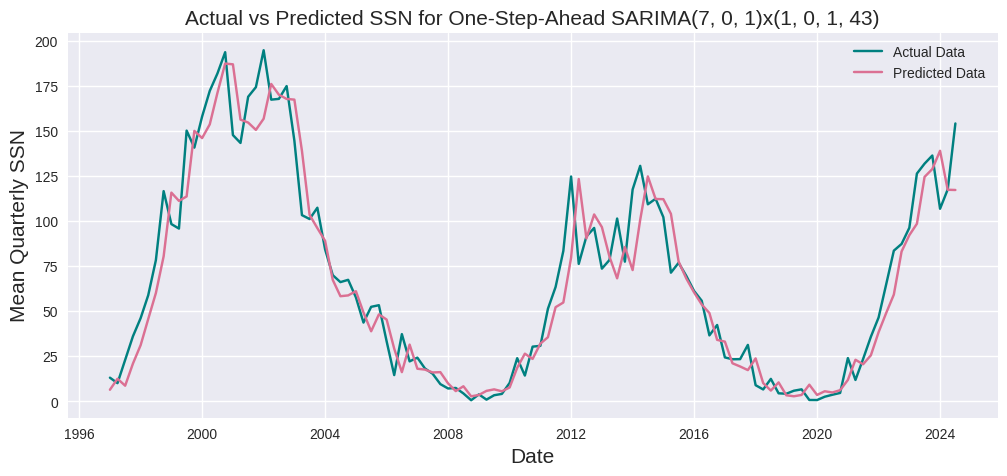

Mean Absolute Error: 11.770998486634934
Mean Squared Error: 268.53025926634325
Root Mean Squared Error: 16.386892910687592
R^2 Score: 0.9109763677057218


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import pandas as pd

# Step 1: Split the data into training and test sets
train_size = int(len(ts_quarter) * 0.90)  # Using 90% of data for training
train, test = ts_quarter.iloc[:train_size], ts_quarter.iloc[train_size:]

# Step 2: Train the model on the full training data
model = sm.tsa.statespace.SARIMAX(train, trend='n', order=(7, 0, 1), seasonal_order=(1, 0, 1, 43))
results = model.fit()
print(results.summary())

# Step 3: Make one-step-ahead predictions for the test set period
predictions = []
history = train.copy()

for t in range(len(test)):
    yhat = results.forecast(steps=1)[0]
    predictions.append(yhat)
    history = pd.concat([history, test.iloc[[t]]])
    results = results.extend([test.iloc[t]])

# Convert predictions to a pandas Series
predictions = pd.Series(predictions, index=test.index)

# Step 5: Plot the actual values and the forecasted values
plt.figure(figsize=(12, 5))
plt.plot(test, label='Actual Data', color='teal')
plt.plot(predictions, label='Predicted Data', color='palevioletred')
plt.legend()
plt.title('Actual vs Predicted SSN for One-Step-Ahead SARIMA(7, 0, 1)x(1, 0, 1, 43)', fontdict={'fontsize': 15})
plt.xlabel('Date', fontdict={'fontsize': 15})
plt.ylabel('Mean Quarterly SSN', fontdict={'fontsize': 15})
plt.show()

# Optional: Evaluate the performance using metrics like Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

                                     SARIMAX Results                                      
Dep. Variable:                    Sunspots_Number   No. Observations:                  991
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 43)   Log Likelihood               -4407.743
Date:                            Tue, 23 Jul 2024   AIC                           8825.486
Time:                                    13:54:44   BIC                           8849.757
Sample:                                03-31-1749   HQIC                          8834.734
                                     - 09-30-1996                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9389      0.011     85.069      0.000       0.917       0.960
ma.L1         -0.1894      0.028   

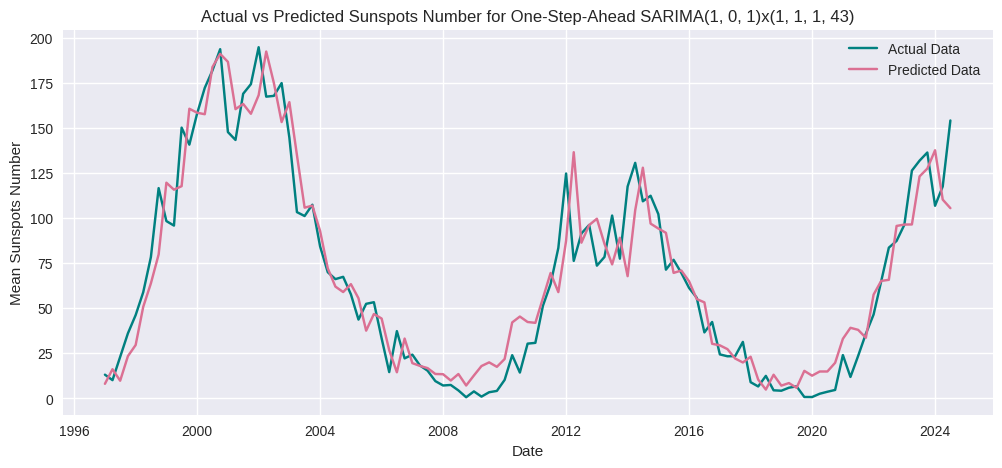

Mean Absolute Error: 13.29058912509827
Mean Squared Error: 304.3229990278771
Root Mean Squared Error: 17.444855947467065
R^2 Score: 0.8991102945412255


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

# Step 1: Split the data into training and test sets
train_size = int(len(ts_quarter) * 0.90)  # Using 90% of data for training
train, test = ts_quarter.iloc[:train_size], ts_quarter.iloc[train_size:]

# Step 2: Train the model on the full training data
model = sm.tsa.statespace.SARIMAX(train, trend='n', order=(1, 0, 1), seasonal_order=(1, 1, 1, 43))
results = model.fit()
print(results.summary())

# Step 3: Make one-step-ahead predictions for the test set period
predictions = []
history = train.copy()

for t in range(len(test)):
    yhat = results.forecast(steps=1)[0]
    predictions.append(yhat)
    history = pd.concat([history, test.iloc[[t]]])
    results = results.extend([test.iloc[t]])

# Convert predictions to a pandas Series
predictions = pd.Series(predictions, index=test.index)

# Step 5: Plot the actual values and the forecasted values
plt.figure(figsize=(12, 5))
plt.plot(test, label='Actual Data', color='teal')
plt.plot(predictions, label='Predicted Data', color='palevioletred')
plt.legend()
plt.title('Actual vs Predicted Sunspots Number for One-Step-Ahead SARIMA(1, 0, 1)x(1, 1, 1, 43)')
plt.xlabel('Date')
plt.ylabel('Mean Sunspots Number')
plt.show()

# Optional: Evaluate the performance using metrics like Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test, predictions)

# Print evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')



In [ ]:
mape = mean_absolute_percentage_error(test, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')


Mean Absolute Percentage Error (MAPE): 1.0138%


In [ ]:
mape

1.0138137862430403

#NN - ML Models

##Autoregressive Neural Networks

To handle the sunspot number time series using autoregressive neural networks, we can use the keras library to build and train an LSTM (Long Short-Term Memory) model. LSTM networks are well-suited for time series forecasting due to their ability to capture long-term dependencies.

Here's how to approach this:

Data Preparation: Normalize the data and create sequences for the LSTM model.
LSTM Model Definition: Define and compile the LSTM model.
Model Training: Train the LSTM model on the training data.
Evaluation and Prediction: Evaluate the model on the test data and make predictions.



Function Definition: Defines a function create_sequences to generate input sequences and corresponding target values. Each sequence is of length seq_length (4 quarters or 1 year in this case).
Sequence Generation: Uses the function to generate sequences from the normalized data.
Reshapes the input sequences into the format required by the LSTM network, i.e., (number of samples, sequence length, number of features).

Define LSTM Model:

Model Architecture: Defines a Sequential LSTM model with:
Two LSTM layers with 50 units each. The first LSTM layer returns sequences, and the second one does not.
Dropout layers to prevent overfitting.
A Dense layer to produce the final output.
Compile Model: Compiles the model using the Adam optimizer and mean squared error loss function.

###LSTM: Basic Default

Epoch 1/100
22/22 [==============================] - 7s 107ms/step - loss: 0.0322 - val_loss: 0.0338
Epoch 2/100
22/22 [==============================] - 1s 42ms/step - loss: 0.0229 - val_loss: 0.0253
Epoch 3/100
22/22 [==============================] - 1s 46ms/step - loss: 0.0177 - val_loss: 0.0168
Epoch 4/100
22/22 [==============================] - 1s 61ms/step - loss: 0.0149 - val_loss: 0.0206
Epoch 5/100
22/22 [==============================] - 2s 74ms/step - loss: 0.0119 - val_loss: 0.0154
Epoch 6/100
22/22 [==============================] - 2s 76ms/step - loss: 0.0116 - val_loss: 0.0087
Epoch 7/100
22/22 [==============================] - 1s 59ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 8/100
22/22 [==============================] - 1s 48ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 9/100
22/22 [==============================] - 1s 47ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 10/100
22/22 [==============================] - 1s 43ms/step - loss: 0.0089 - val_loss: 0.010

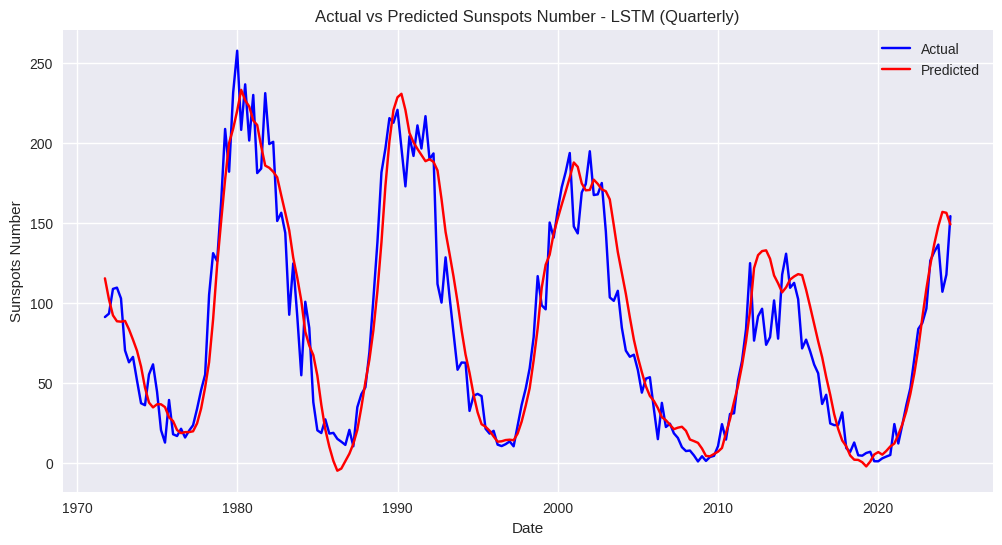

        Date      Actual   Predicted
0 1971-09-30   91.000000  115.211159
1 1971-12-31   93.133333  102.055305
2 1972-03-31  108.600000   92.074028
3 1972-06-30  109.400000   88.363892
4 1972-09-30  102.633333   88.110703
5 1972-12-31   70.133333   88.597672
6 1973-03-31   62.700000   83.323730
7 1973-06-30   66.066667   76.864952
8 1973-09-30   51.300000   69.909981
9 1973-12-31   37.100000   60.077515


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Assuming df is your dataframe with a Date column and a Sunspots_Number column
# Ensure the Date column is a datetime type
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample the data to quarterly frequency
df_quarterly = df.resample('Q').mean()

# Normalize the data
scaler = MinMaxScaler()
df_quarterly['Sunspots_Number'] = scaler.fit_transform(df_quarterly[['Sunspots_Number']])

# Add cyclical features for the solar cycle (11 years)
df_quarterly['Cycle_Sine'] = np.sin(2 * np.pi * (df_quarterly.index.year % 11) / 11)
df_quarterly['Cycle_Cosine'] = np.cos(2 * np.pi * (df_quarterly.index.year % 11) / 11)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 44  # 44 quarters (11 years) sequence
features = df_quarterly[['Sunspots_Number', 'Cycle_Sine', 'Cycle_Cosine']].values
X, y = create_sequences(features, seq_length)

# Split the data into training and testing sets
split_ratio = 0.9
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Define LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train[:, 0], epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Make predictions
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test[:, 0].reshape(-1, 1))

# Evaluate the model
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(df_quarterly.index[split_index + seq_length:], y_test_rescaled, label='Actual', color='b')
plt.plot(df_quarterly.index[split_index + seq_length:], y_pred_rescaled, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.title('Actual vs Predicted Sunspots Number - LSTM (Quarterly)')
plt.legend()
plt.show()

# Display actual data, date, and predictions of the best model
result_df = pd.DataFrame({
    'Date': df_quarterly.index[split_index + seq_length:],
    'Actual': y_test_rescaled.flatten(),
    'Predicted': y_pred_rescaled.flatten()
})

print(result_df.head(10))  # Print the first 10 rows of the result


With cross validation and before hand split

Split Data: First, split your data into training and test sets. This test set will be set aside and not used during training or cross-validation.

Cross-Validation: Perform cross-validation on the training set only. This helps in training and evaluating the model multiple times on different subsets of the training data.

Prediction on Test Set: After training the model using cross-validation on the training set, make predictions on the test set to evaluate the model's performance.

6/6 [==============================] - 2s 21ms/step
Average Mean Absolute Error (MAE) across 5 folds on validation set: 16.9070
Average Mean Squared Error (MSE) across 5 folds on validation set: 497.1807
Average Root Mean Squared Error (RMSE) across 5 folds on validation set: 22.2709
7/7 [==============================] - 1s 14ms/step

Mean Absolute Error (MAE) on test set: 15.0151
Mean Squared Error (MSE) on test set: 368.4550
Root Mean Squared Error (RMSE) on test set: 19.1952


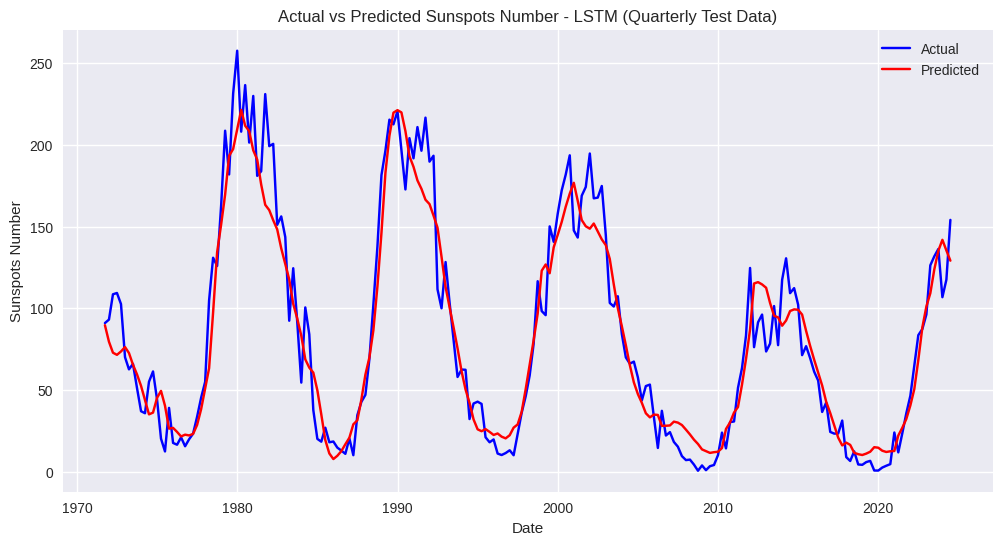

        Date      Actual  Predicted
0 1971-09-30   91.000000  89.703918
1 1971-12-31   93.133333  79.587479
2 1972-03-31  108.600000  72.872910
3 1972-06-30  109.400000  71.576019
4 1972-09-30  102.633333  73.637230
5 1972-12-31   70.133333  76.326248
6 1973-03-31   62.700000  72.666847
7 1973-06-30   66.066667  65.561165
8 1973-09-30   51.300000  59.611290
9 1973-12-31   37.100000  52.600750


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from sklearn.model_selection import KFold
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# # Assuming df is your dataframe with a Date column and a Sunspots_Number column
# # Ensure the Date column is a datetime type
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# # Resample the data to quarterly frequency
# df_quarterly = df.resample('Q').mean()

# # Normalize the data
# scaler = MinMaxScaler()
# df_quarterly['Sunspots_Number'] = scaler.fit_transform(df_quarterly[['Sunspots_Number']])

# # Add cyclical features for the solar cycle (11 years)
# df_quarterly['Cycle_Sine'] = np.sin(2 * np.pi * (df_quarterly.index.year % 11) / 11)
# df_quarterly['Cycle_Cosine'] = np.cos(2 * np.pi * (df_quarterly.index.year % 11) / 11)

# # Create sequences
# def create_sequences(data, seq_length):
#     X = []
#     y = []
#     for i in range(len(data) - seq_length):
#         X.append(data[i:i+seq_length])
#         y.append(data[i+seq_length])
#     return np.array(X), np.array(y)

# seq_length = 44  # 44 quarters (11 years) sequence
# features = df_quarterly[['Sunspots_Number', 'Cycle_Sine', 'Cycle_Cosine']].values
# X, y = create_sequences(features, seq_length)

# # Split the data into training and testing sets
# split_ratio = 0.8
# split_index = int(len(X) * split_ratio)
# X_train, X_test = X[:split_index], X[split_index:]
# y_train, y_test = y[:split_index], y[split_index:]

# # Reshape data for LSTM
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# # Define LSTM model
# def create_model():
#     model = Sequential()
#     model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
#     model.add(Dropout(0.2))
#     model.add(LSTM(50, return_sequences=False))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# # Initialize KFold instance
# n_splits = 5  # Example: Use 5-fold cross-validation
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Lists to store evaluation metrics across folds
# mae_scores = []
# mse_scores = []
# rmse_scores = []

# # Perform cross-validation on the training set
# for train_index, val_index in kf.split(X_train):
#     X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
#     y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

#     model = create_model()
#     early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#     history = model.fit(X_train_fold, y_train_fold[:, 0], epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold[:, 0]), callbacks=[early_stop], verbose=0)

#     # Make predictions on the validation set
#     y_pred = model.predict(X_val_fold)
#     y_pred_rescaled = scaler.inverse_transform(y_pred)
#     y_val_rescaled = scaler.inverse_transform(y_val_fold[:, 0].reshape(-1, 1))

#     # Calculate evaluation metrics for this fold
#     mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
#     mse = mean_squared_error(y_val_rescaled, y_pred_rescaled)
#     rmse = np.sqrt(mse)

#     # Append scores to lists
#     mae_scores.append(mae)
#     mse_scores.append(mse)
#     rmse_scores.append(rmse)

# # Average scores across all folds
# avg_mae = np.mean(mae_scores)
# avg_mse = np.mean(mse_scores)
# avg_rmse = np.mean(rmse_scores)

# print(f"Average Mean Absolute Error (MAE) across {n_splits} folds on validation set: {avg_mae:.4f}")
# print(f"Average Mean Squared Error (MSE) across {n_splits} folds on validation set: {avg_mse:.4f}")
# print(f"Average Root Mean Squared Error (RMSE) across {n_splits} folds on validation set: {avg_rmse:.4f}")

# # Now, make predictions on the test set
# model = create_model()
# model.fit(X_train, y_train[:, 0], epochs=100, batch_size=32, verbose=0)

# y_pred = model.predict(X_test)
# y_pred_rescaled = scaler.inverse_transform(y_pred)
# y_test_rescaled = scaler.inverse_transform(y_test[:, 0].reshape(-1, 1))

# # Calculate evaluation metrics on the test set
# mae_test = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
# mse_test = mean_squared_error(y_test_rescaled, y_pred_rescaled)
# rmse_test = np.sqrt(mse_test)

# print(f"\nMean Absolute Error (MAE) on test set: {mae_test:.4f}")
# print(f"Mean Squared Error (MSE) on test set: {mse_test:.4f}")
# print(f"Root Mean Squared Error (RMSE) on test set: {rmse_test:.4f}")

# # Plot actual vs predicted for the test set
# plt.figure(figsize=(12, 6))
# plt.plot(df_quarterly.index[split_index + seq_length:], y_test_rescaled, label='Actual', color='b')
# plt.plot(df_quarterly.index[split_index + seq_length:], y_pred_rescaled, label='Predicted', color='r')
# plt.xlabel('Date')
# plt.ylabel('Sunspots Number')
# plt.title('Actual vs Predicted Sunspots Number - LSTM (Quarterly Test Data)')
# plt.legend()
# plt.show()

# # Display actual data, date, and predictions of the best model
# result_df = pd.DataFrame({
#     'Date': df_quarterly.index[split_index + seq_length:],
#     'Actual': y_test_rescaled.flatten(),
#     'Predicted': y_pred_rescaled.flatten()
# })

# print(result_df.head(10))  # Print the first 10 rows of the result


###LSTM Grid


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, ParameterGrid
import tensorflow as tf

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Assuming df is your dataframe with a Date column and a Sunspots_Number column
# Ensure the Date column is a datetime type
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample the data to quarterly frequency
df_quarterly = df.resample('Q').mean()

# Normalize the data
scaler = MinMaxScaler()
df_quarterly['Sunspots_Number'] = scaler.fit_transform(df_quarterly[['Sunspots_Number']])

# Add cyclical features for the solar cycle (11 years)
df_quarterly['Cycle_Sine'] = np.sin(2 * np.pi * (df_quarterly.index.year % 44) / 44)
df_quarterly['Cycle_Cosine'] = np.cos(2 * np.pi * (df_quarterly.index.year % 44) / 44)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 44  # 44 quarters (11 years) sequence
features = df_quarterly[['Sunspots_Number', 'Cycle_Sine', 'Cycle_Cosine']].values
X, y = create_sequences(features, seq_length)

# Split the data into training and testing sets
split_ratio = 0.9
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Define a function to create the model
def create_model(num_units, dropout_rate):
    model = Sequential()
    model.add(LSTM(num_units, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(num_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Hyperparameter grid
param_grid = {
    'num_units': [ 50],
    'dropout_rate': [0.2],
    'batch_size': [16]
}

# Initialize KFold instance
n_splits = 5  # Example: Use 5-fold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store evaluation metrics and best parameters
best_params = None
best_rmse = float('inf')

# Perform grid search with cross-validation
for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    mae_scores = []
    mse_scores = []
    rmse_scores = []
    r2_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = create_model(params['num_units'], params['dropout_rate'])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train_fold, y_train_fold[:, 0], epochs=500, batch_size=params['batch_size'], validation_data=(X_val_fold, y_val_fold[:, 0]), callbacks=[early_stop], verbose=0)

        # Make predictions on the validation set
        y_pred = model.predict(X_val_fold)
        y_pred_rescaled = scaler.inverse_transform(y_pred)
        y_val_rescaled = scaler.inverse_transform(y_val_fold[:, 0].reshape(-1, 1))

        # Calculate evaluation metrics for this fold
        mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
        mse = mean_squared_error(y_val_rescaled, y_pred_rescaled)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_rescaled, y_pred_rescaled)

        # Append scores to lists
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

    # Average scores across all folds for this set of hyperparameters
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    print(f"Average RMSE: {avg_rmse:.4f}")
    print(f"Average R²: {avg_r2:.4f}")

    # Update best parameters if current RMSE is better
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = params

print(f"\nBest parameters: {best_params}")
print(f"Best RMSE: {best_rmse:.4f}")

# Train final model with best parameters on full training data
final_model = create_model(best_params['num_units'], best_params['dropout_rate'])
final_model.fit(X_train, y_train[:, 0], epochs=100, batch_size=best_params['batch_size'], verbose=0)

# Evaluate on test set
y_pred_test = final_model.predict(X_test)
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_test_rescaled = scaler.inverse_transform(y_test[:, 0].reshape(-1, 1))


Testing parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'num_units': 50}
6/6 [==============================] - 1s 21ms/step
Average RMSE: 22.9212
Average R²: 0.8797

Best parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'num_units': 50}
Best RMSE: 22.9212
4/4 [==============================] - 1s 14ms/step


In [ ]:
import matplotlib.dates as mdates

In [ ]:
# Train final model with best parameters on full training data
early_stop = EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)
final_model = create_model(best_params['num_units'], best_params['dropout_rate'])
final_model.fit(X_train, y_train[:, 0], epochs=300, batch_size=best_params['batch_size'], callbacks=[early_stop], verbose=0)

# Evaluate on test set
y_pred_test = final_model.predict(X_test)
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_test_rescaled = scaler.inverse_transform(y_test[:, 0].reshape(-1, 1))

4/4 [==============================] - 1s 13ms/step



Mean Absolute Error (MAE) on test set: 14.0707
Mean Squared Error (MSE) on test set: 323.1185
Root Mean Squared Error (RMSE) on test set: 17.9755
R²: 0.8945
MAPE: 123.62%


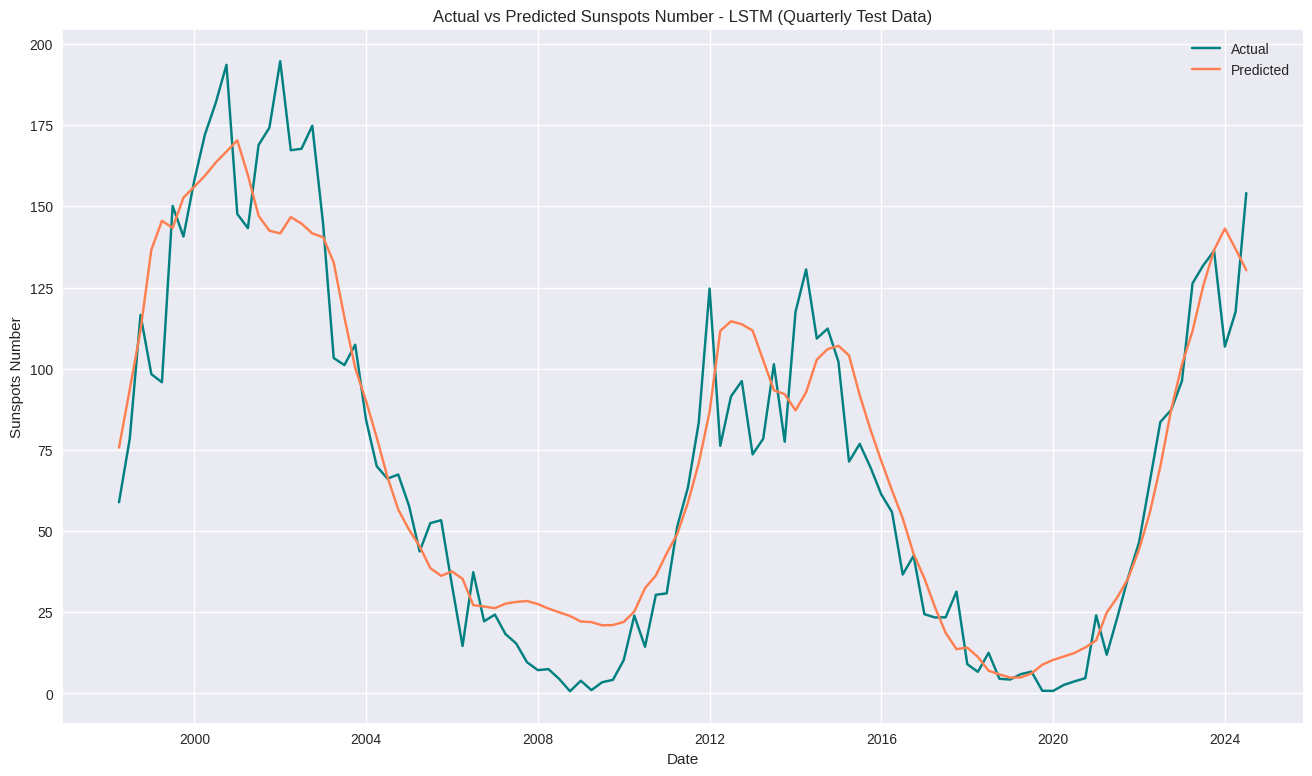

        Date      Actual   Predicted
0 1998-03-31   58.900000   75.735153
1 1998-06-30   78.366667   93.547813
2 1998-09-30  116.600000  111.882065
3 1998-12-31   98.333333  136.643890
4 1999-03-31   95.833333  145.566849
5 1999-06-30  150.133333  143.377121
6 1999-09-30  140.700000  152.685471
7 1999-12-31  157.933333  156.047623
8 2000-03-31  172.166667  159.436432
9 2000-06-30  181.800000  163.485611


In [ ]:
# Calculate evaluation metrics on the test set
mae_test = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
mse_test = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
rmse_test = np.sqrt(mse_test)
test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)
mape_test = np.mean(np.abs((y_test_rescaled - y_pred_test_rescaled) / y_test_rescaled)) * 100

print(f"\nMean Absolute Error (MAE) on test set: {mae_test:.4f}")
print(f"Mean Squared Error (MSE) on test set: {mse_test:.4f}")
print(f"Root Mean Squared Error (RMSE) on test set: {rmse_test:.4f}")
print(f"R²: {test_r2:.4f}")
print(f"MAPE: {mape_test:.2f}%")

# Plot actual vs predicted for the test set
plt.plot(df_quarterly.index[split_index + seq_length:], y_test_rescaled, label='Actual', color='teal')
plt.plot(df_quarterly.index[split_index + seq_length:], y_pred_test_rescaled, label='Predicted', color='coral')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.title('Actual vs Predicted Sunspots Number - LSTM (Quarterly Test Data)')
plt.legend()
plt.show()

# Display actual data, date, and predictions of the best model
result_df = pd.DataFrame({
    'Date': df_quarterly.index[split_index + seq_length:],
    'Actual': y_test_rescaled.flatten(),
    'Predicted': y_pred_test_rescaled.flatten()
})

print(result_df.head(10))  # Print the first 10 rows of the result

###LSTM NEW ONE STEP

In [ ]:
!pip install KerasRegressor

ERROR: Could not find a version that satisfies the requirement KerasRegressor (from versions: none)
ERROR: No matching distribution found for KerasRegressor


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [ ]:
# Assuming 'df' is a pandas DataFrame with the sunspots data
# and 'Sunspots_Number' is the column with the quarterly sunspot numbers.

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample the data to quarterly frequency
df_quarterly = df.resample('Q').mean()

# Normalize data
mean_val = df_quarterly['Sunspots_Number'].mean()
std_val = df_quarterly['Sunspots_Number'].std()

df_quarterly['Sunspots_Number'] = (df_quarterly['Sunspots_Number'] - mean_val) / std_val

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 44  # 11 years of quarterly data
X, y = create_sequences(df_quarterly['Sunspots_Number'].values, seq_length)

# Split data
split_idx = int(len(X) * 0.9)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
def build_model(optimizer, units):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mae')
    return model


In [ ]:
# Hyperparameters to try
param_grid = {
    'batch_size': [16,32],
    'epochs': [50],
    'units': [300, 400],
    'optimizer': ['rmsprop']
}

best_score = float('inf')
best_params = None
best_model = None

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for units in param_grid['units']:
            for optimizer in param_grid['optimizer']:
                model = build_model(optimizer=optimizer, units=units)
                early_stopping = EarlyStopping(monitor='val_loss', patience=10)
                history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                    validation_split=0.1, callbacks=[early_stopping], verbose=0)

                # Evaluate the model
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)

                if mse < best_score:
                    best_score = mse
                    best_params = {'batch_size': batch_size, 'epochs': epochs, 'units': units, 'optimizer': optimizer}
                    best_model = model

print(f"Best Params: {best_params}")


4/4 [==============================] - 0s 53ms/step
Best Params: {'batch_size': 16, 'epochs': 50, 'units': 300, 'optimizer': 'rmsprop'}


In [ ]:
# One-Step-Ahead Prediction
predictions = []
current_input = X_test[0]  # Start with the first test sequence

for i in range(len(y_test)):
    # Make prediction
    pred = best_model.predict(current_input.reshape((1, seq_length, 1)), verbose=0)
    predictions.append(pred[0][0])

    # Shift the input sequence and add the actual next value if available
    if i + 1 < len(y_test):
        current_input = np.roll(current_input, -1)
        current_input[-1] = y_test[i + 1]  # Use the next actual value
    else:
        # Shift the input and add the predicted value at the end
        current_input = np.roll(current_input, -1)
        current_input[-1] = pred  # Last actual value is replaced by prediction

# Convert predictions and true values back to original scale
predictions = np.array(predictions) * std_val + mean_val
y_test = y_test * std_val + mean_val


MAE: 9.662115620067286
RMSE: 12.462923546160837
R²: 0.9493001289864861


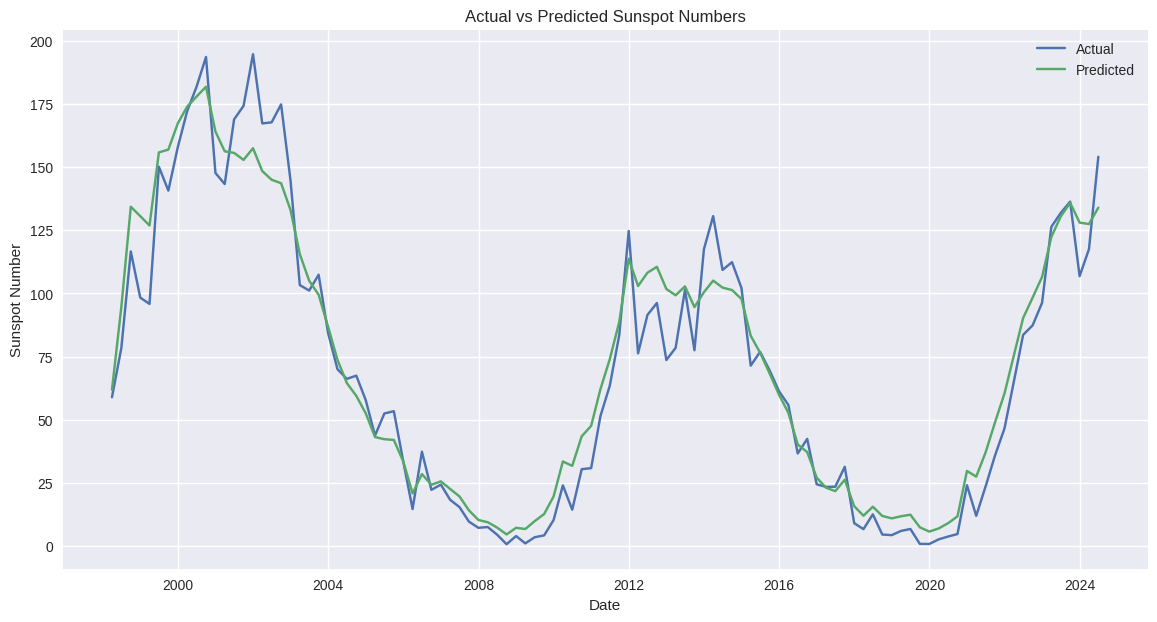

In [ ]:
# Get the test dates
test_dates = df_quarterly.index[-len(y_test):]

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")



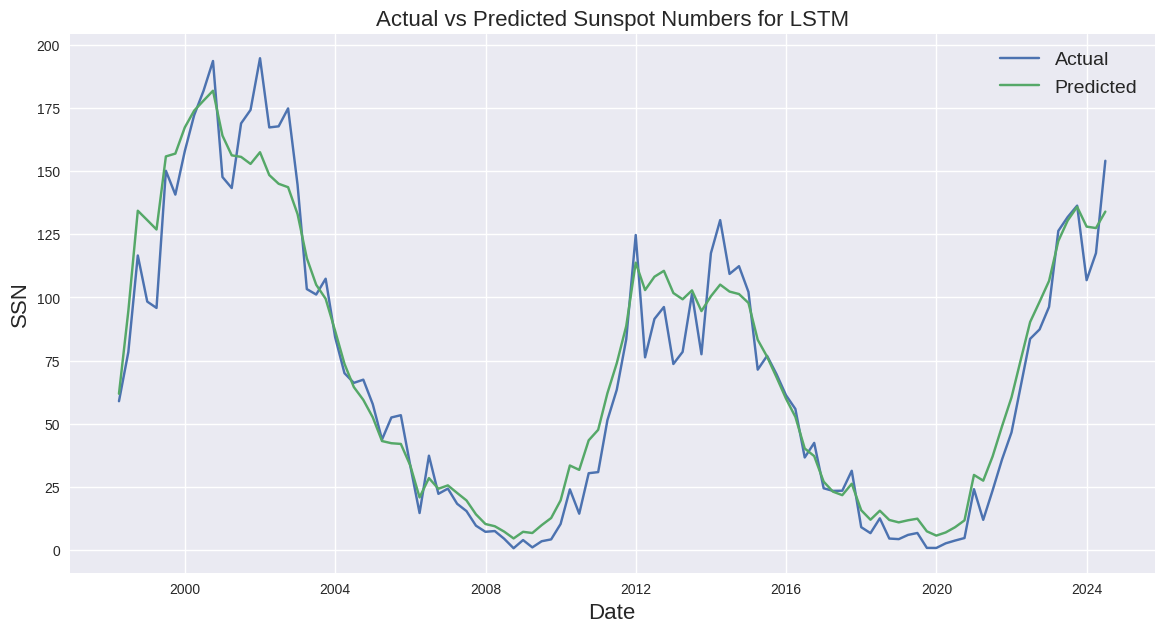

In [ ]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, predictions, label='Predicted')
plt.xlabel('Date', fontdict = {'fontsize':16})
plt.ylabel('SSN', fontdict = {'fontsize':16})
plt.title('Actual vs Predicted Sunspot Numbers for LSTM', fontdict = {'fontsize':16})
plt.legend(fontsize=14)
plt.show()


##LGBM - X-Boost

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from timeit import default_timer as timers
import pickle
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

# Define column names based on the description
column_names = ['Year', 'Month', 'Date_Fraction', 'Sunspots_Number', 'St_Deviation', 'Nobs', 'Indicator']

# Read the CSV file and add column names
df = pd.read_csv('/content/drive/MyDrive/Monthly_Sunspots.csv', sep=';', names=column_names)

# Count missing values in 'Sunspots_Number'
missing_values = df['Sunspots_Number'].value_counts()
num_missing_values = missing_values[-1] if -1 in missing_values else 0

# Delete rows with missing values in 'Sunspots_Number'
df = df[df['Sunspots_Number'] != -1]

# Keep only the specified columns
df = df[['Year', 'Month', 'Date_Fraction', 'Sunspots_Number']]

# Display the resulting DataFrame
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))  # Add a date column with 1
df = df[['Date', 'Year', 'Month', 'Date_Fraction', 'Sunspots_Number']]
df

###Monthly Train - Test

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
import lightgbm as lgb

# Load and prepare the data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split data into train and test sets
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define lagged features
lags = [1, 6, 24]  # lagged values for 1 quarter and 1 year (4 quarters)

for lag in lags:
    train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)

# Prepare the training data for grid search
X_train = train.drop(columns=['Sunspots_Number'])
y_train = train['Sunspots_Number']

# Define the parameter grid for XGBoost and LightGBM
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8],
}

param_grid_lgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8],
}

# Initialize models
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
lgb_model = lgb.LGBMRegressor(objective='regression')

# Perform grid search with cross-validation for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error')
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# Perform grid search with cross-validation for LightGBM
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error')
grid_search_lgb.fit(X_train, y_train)
best_lgb = grid_search_lgb.best_estimator_

# Evaluate both models on the test set
X_test = test.drop(columns=['Sunspots_Number'])
y_test = test['Sunspots_Number']

best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)

best_lgb.fit(X_train, y_train)
lgb_preds = best_lgb.predict(X_test)

# Compute test set metrics for both models
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)

lgb_mae = mean_absolute_error(y_test, lgb_preds)
lgb_mse = mean_squared_error(y_test, lgb_preds)
lgb_rmse = np.sqrt(lgb_mse)

# Determine the best model based on MAE
best_model_name = 'XGBoost' if xgb_mae < lgb_mae else 'LightGBM'
best_model_preds = xgb_preds if best_model_name == 'XGBoost' else lgb_preds

# Prepare the data for plotting
test_results = pd.DataFrame({
    'Actual': y_test,
    'XGBoost_Predicted': xgb_preds,
    'LightGBM_Predicted': lgb_preds
}, index=test.index)

# Resample data for quarterly and yearly plotting
test_results_quarterly = test_results.resample('Q').mean()
test_results_yearly = test_results.resample('Y').mean()

# Plotting quarterly data
plt.figure(figsize=(15, 7))
plt.plot(test_results_quarterly.index, test_results_quarterly['Actual'], label='Actual (Quarterly)', color='teal')
plt.plot(test_results_quarterly.index, test_results_quarterly['XGBoost_Predicted'], label='XGBoost Prediction (Quarterly)', color='orchid')
plt.plot(test_results_quarterly.index, test_results_quarterly['LightGBM_Predicted'], label='LightGBM Prediction (Quarterly)', color='coral')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('Test Set Predictions (Quarterly)')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.grid(True)
plt.show()

# Plotting yearly data
plt.figure(figsize=(15, 7))
plt.plot(test_results_yearly.index, test_results_yearly['Actual'], label='Actual (Yearly)', color='teal')
plt.plot(test_results_yearly.index, test_results_yearly['XGBoost_Predicted'], label='XGBoost Prediction (Yearly)', color='orchid')
plt.plot(test_results_yearly.index, test_results_yearly['LightGBM_Predicted'], label='LightGBM Prediction (Yearly)', color='coral')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('Test Set Predictions (Yearly)')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.grid(True)
plt.show()

# Print results
print(f"Best Parameters from Grid Search for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best Parameters from Grid Search for LightGBM: {grid_search_lgb.best_params_}")

print(f"\nTest Set Metrics for XGBoost:")
print(f"MAE={xgb_mae}, MSE={xgb_mse}, RMSE={xgb_rmse}")

print(f"\nTest Set Metrics for LightGBM:")
print(f"MAE={lgb_mae}, MSE={lgb_mse}, RMSE={lgb_rmse}")

print(f"\nBest Model: {best_model_name}")
print(f"MAE={min(xgb_mae, lgb_mae)}, MSE={min(xgb_mse, lgb_mse)}, RMSE={min(xgb_rmse, lgb_rmse)}")
